<a href="https://colab.research.google.com/github/jewelprince/ML-Experiments/blob/main/SimpleDemandForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Training a simple ML model to predict demand for items**

In [ ]:
%pip install -Uq upgini catboost

In [ ]:
from os.path import exists
import pandas as pd

# Checking if file is already downloaded
df_path = 'train.csv.zip' if exists('train.csv.zip') else "https://github.com/upgini/upgini/raw/main/notebooks/train.csv.zip"
df = pd.read_csv(df_path)
# Sampling a smaller subset of data to stay within upgini limits
df = df.sample(n=500, random_state=0) # Sample 500 rows in total
df["store"] = df["store"].astype(str)
df["item"] = df["item"].astype(str)

df["date"] = pd.to_datetime(df["date"])

df.sort_values("date", inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,date,store,item,sales
0,2013-01-01,5,24,26
1,2013-01-03,6,21,23
2,2013-01-05,9,37,12
3,2013-01-07,5,49,15
4,2013-01-08,5,6,20


In [ ]:
#Splitting data into training and testing sets
train = df[df["date"] < "2017-01-01"]
test = df[df["date"] >= "2017-01-01"]

In [ ]:
#Allocating features and target variables
train_features = train.drop(columns=["sales"])
train_target = train["sales"]
test_features = test.drop(columns=["sales"])
test_target = test["sales"]


In [ ]:
#Using upgini to supplement scarce data (enriching features)
from upgini import FeaturesEnricher, SearchKey
from upgini.metadata import CVType

enricher = FeaturesEnricher(
    search_keys={
        "date": SearchKey.DATE,
    },
    cv = CVType.time_series
)
enricher.fit(train_features,
             train_target,
             eval_set = [(test_features, test_target)])

[============================================================] 100% Finished

WARNING #1: Search started with DATE search key only
Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IP to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history


Detected task type: ModelTaskType.REGRESSION. Reason: date search key is present, treating as regression
You can set task type manually with argument `model_task_type` of FeaturesEnricher constructor if task type detected incorrectly

WARNING #2: Your training sample is unstable in number of rows per date. It is recommended to redesign the training sample



Column name,Status,Errors
date,All valid,-
target,All valid,-




Running search request, search_id=5a4b2f5c-8d7d-4c4f-bf22-2f986a6883c9
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com



f_autofe_roll_3d_min_042ad81493,0.4187,100.0000,"13.0, 95.0, 26.0",Training dataset,AutoFE: features from Training dataset,
f_autofe_roll_3d_q25_bbdfb6ad19,0.2759,100.0000,"38.75, 32.25, 48.25",Training dataset,AutoFE: features from Training dataset,


Training dataset,AutoFE: features from Training dataset,0.6946,2


Training dataset,f_autofe_roll_3d_min_042ad81493,target,roll_3d_min
Training dataset,f_autofe_roll_3d_q25_bbdfb6ad19,target,roll_3d_q25


In [ ]:
from catboost import CatBoostRegressor
from catboost.utils import eval_metric

model = CatBoostRegressor(verbose=False, allow_writing_files=False, random_state=0)

# Calculate baseline model performance before enrichment
enricher.calculate_metrics(
    train_features, train_target,
    eval_set=[(test_features, test_target)],
    estimator=model,
    scoring="mean_absolute_percentage_error"
)

Calculating accuracy uplift after enrichment...


,Dataset type,Rows,Mean target,Enriched MAPE
0,Train,246,55.1260,0.283 ± 0.111
1,Eval 1,99,59.3131,0.222 ± 0.021


In [ ]:
enriched_train_features = enricher.transform(train_features, y=train_target, keep_input=True)
enriched_test_features = enricher.transform(test_features, y=test_target, keep_input=True)
enriched_train_features.head()

[============================================================] 100% Finished

You use Trial access to Upgini data enrichment. Limit for Trial: 1000 rows. You have already enriched: 141 rows.
WARNING #1: Search started with DATE search key only
Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IP to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history

WARNING #2: 20.9476% of rows (84) in X and eval_set are duplicates with different y values. These rows will be deleted as incorrect
Sample of incorrect row indexes: [25, 26, 36, 37, 62, 63, 66, 67, 70, 71, 73, 74, 80, 81, 92, 93, 104, 105, 106, 107, 112, 113, 123, 124, 136, 137, 139, 140, 145, 146, 147, 148, 161, 162, 164, 165, 171, 172, 176, 177, 194, 195, 198, 199, 207, 208, 224, 225, 235, 236, 242, 243, 258, 259, 265, 266, 270, 271, 289, 290, 305, 306, 313, 314, 334, 335, 337, 338, 357, 358, 361, 362, 367, 368, 371, 372, 376, 377, 378, 379, 383, 384, 385, 386]



Column name,Status,Errors
date,All valid,-




Running transform request, id=1cb74d4f-b6fe-4897-953b-91a4e21d8da8
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com

Retrieving selected features from data sources...


[============================================================] 100% Finished

You use Trial access to Upgini data enrichment. Limit for Trial: 1000 rows. You have already enriched: 458 rows.
WARNING #1: Search started with DATE search key only
Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IP to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history

WARNING #2: 17.3469% of rows (17) in X and eval_set are duplicates with different y values. These rows will be deleted as incorrect
Sample of incorrect row indexes: [13, 14, 18, 19, 35, 36, 48, 49, 50, 66, 67, 79, 80, 92, 93, 94, 95]



Column name,Status,Errors
date,All valid,-




Running transform request, id=c313e646-16da-4aff-bcff-ebb06a40cb9c
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com

Retrieving selected features from data sources...


,date,target,f_autofe_roll_3d_min_042ad81493,f_autofe_roll_3d_q25_bbdfb6ad19
0,2013-01-01,26,26.0,26.00
1,2013-01-03,23,23.0,23.75
2,2013-01-05,12,12.0,14.75
3,2013-01-07,15,12.0,12.75
4,2013-01-08,20,15.0,16.25


In [ ]:
#Finding percent error with unenriched data
model.fit(train_features, train_target)
preds = model.predict(test_features)
eval_metric(test_target.values, preds, "SMAPE")

[34.06565914181616]

In [ ]:
#Finding percent error with enriched data
model.fit(enriched_train_features, train_target)
enriched_preds = model.predict(enriched_test_features)
eval_metric(test_target.values, enriched_preds, "SMAPE")

[1.8857466443108781]

**Reasoning**:
Create a DataFrame with actual and predicted sales for both models and then melt it for plotting.



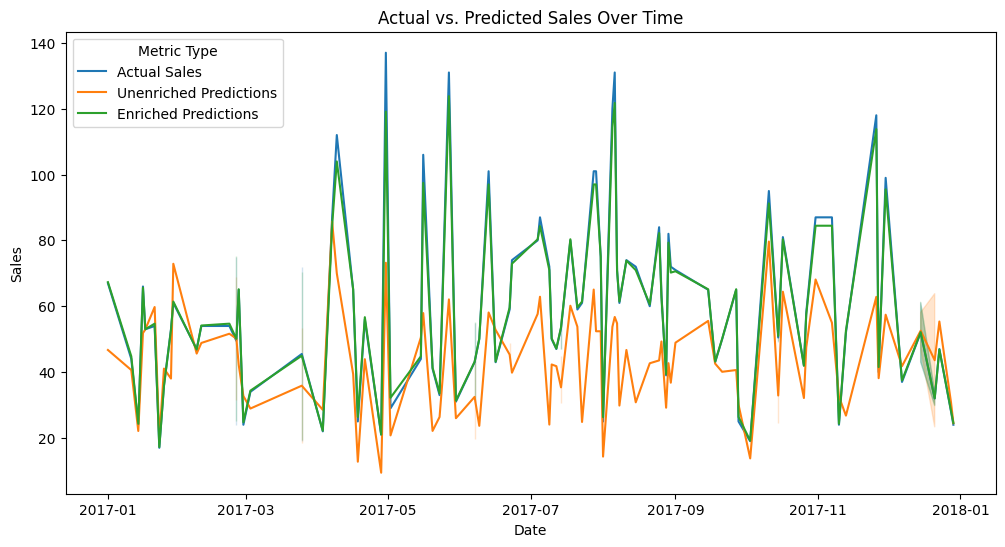

In [ ]:
#Generate plots to compare actual sales vs. predictions for both models and visualize trends over time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

performance_df = pd.DataFrame({
    'date': test_features['date'],
    'Actual Sales': test_target,
    'Unenriched Predictions': preds,
    'Enriched Predictions': enriched_preds
})

performance_df_melted = performance_df.melt(id_vars='date',
                                            value_vars=['Actual Sales', 'Unenriched Predictions', 'Enriched Predictions'],
                                            var_name='Metric Type',
                                            value_name='Sales Value')

plt.figure(figsize=(12, 6))
sns.lineplot(data=performance_df_melted, x='date', y='Sales Value', hue='Metric Type')
plt.title('Actual vs. Predicted Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Analyze feature importance

### Subtask:
Get and visualize feature importance scores from the enriched model.


**Reasoning**:
Access and visualize feature importance scores from the fitted CatBoost model trained on enriched data.



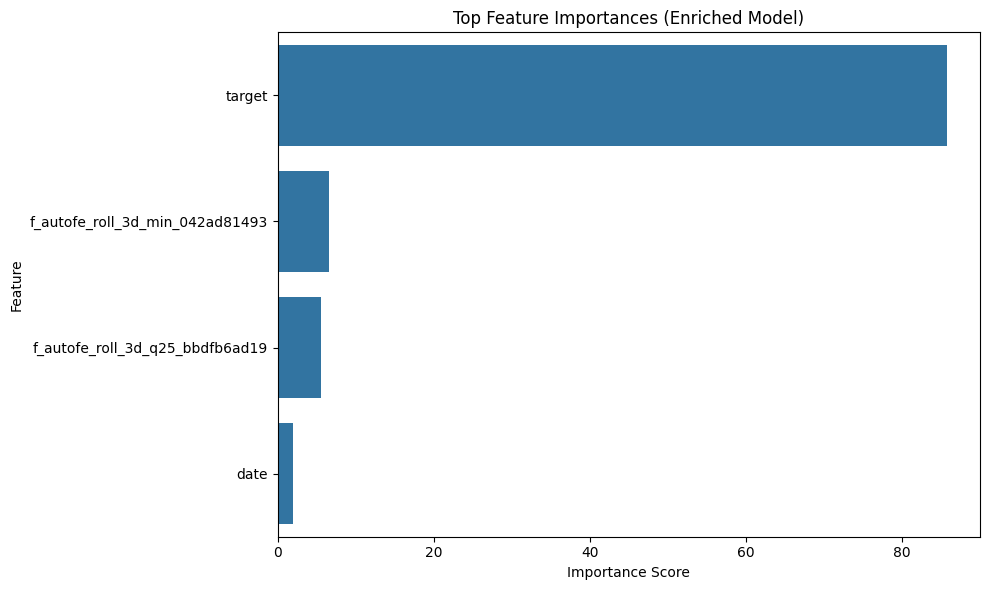

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the fitted model
feature_importance = model.get_feature_importance()

# Create a pandas Series with feature names and importance scores
feature_names = enriched_train_features.columns
feature_importance_series = pd.Series(feature_importance, index=feature_names)

# Sort feature importances in descending order
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

# Select top N features (e.g., top 10 or all if less than 10)
n_features = min(10, len(sorted_feature_importance))
top_n_features = sorted_feature_importance.head(n_features)

# Create a bar plot of the top features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_n_features.values, y=top_n_features.index)
plt.title('Top Feature Importances (Enriched Model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Model Performance Visualization**

The plot visualizes the performance of both the unenriched and enriched models over time. It shows the actual sales values alongside the predictions from the unenriched and enriched models.

By examining how closely the predicted lines (orange and green) follow the actual sales line (blue), we can visually assess each model's accuracy and how enrichment has impacted the prediction quality. A better-performing model will have its prediction line closer to the actual sales line.


**Feature Importance Analysis**

 The bar plot below illustrates the importance of different features in the enriched model's predictions. Feature importance indicates how much each feature contributes to the model's decision-making process.
 Features with longer bars have a greater influence on the predictions. By analyzing this plot, we can identify which factors were most significant in predicting sales according to the enriched model.


## Summary:

### Data Analysis Key Findings

*   A line plot comparing the actual sales against the predictions from both the unenriched and enriched models over time was successfully generated.
*   A bar plot visualizing the top 10 feature importance scores from the enriched model was successfully generated.
*   Markdown cells explaining the model performance visualization and the feature importance plot were added to the notebook.

### Insights or Next Steps

*   The visualizations provide a clear way to visually compare the performance of the two models and understand which features are most influential in the enriched model.
*   These plots and explanations should be integrated into the final report or presentation to effectively communicate the model's performance and the impact of feature enrichment.
